# Feedback Cancellation of the Double Pendulum

Let's say that we would like our simple double pendulum to act like a
simple single pendulum (with damping), whose dynamics are given by:
\begin{align*} \ddot \theta_1 &= -\frac{g}{l}\sin\theta_1 -b\dot\theta_1 \\
\ddot\theta_2 &= 0. \end{align*} This is easily achieved using
(Note that our chosen dynamics do not actually stabilize $\theta_2$ -- this detail was left out for clarity, but would be necessary for any real
implementation.) $${\bf u}  = {\bf B}^{-1}\left[ {\bf C}\dot{{\bf q}} - {\bf \tau}_g +
{\bf M}\begin{bmatrix} -\frac{g}{l}s_1 - b\dot{q}_1 \\ 0 \end{bmatrix}
\right].$$ 

Since we are embedding a nonlinear dynamics (not a linear one), we refer
to this as "feedback cancellation", or "dynamic inversion".  This idea can,
and does, make control look easy - for the special case of a fully-actuated
deterministic system with known dynamics.  For example, it would have been
just as easy for me to invert gravity. Observe that the control derivations
here would not have been any more difficult if the robot had 100 joints.

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

## Acting like a single pendulum

First we implement our simple controller as a system that takes the pendulum state in, and outputs the motor torque.

In [2]:
from math import sin
from IPython import get_ipython

from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, Parser,
                         PlanarSceneGraphVisualizer, Simulator, VectorSystem)
from underactuated import FindResource, ManipulatorDynamics
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()


class Controller(VectorSystem):
    """Defines a feedback controller for the double pendulum.

    The controller applies torques at the joints in order to:

    1) cancel out the dynamics of the double pendulum,
    2) make the first joint swing with the dynamics of a single pendulum, and
    3) drive the second joint towards zero.

    The magnitude of gravity for the imposed single pendulum dynamics is taken
    as a constructor argument.  So you can do fun things like pretending that
    gravity is zero, or even inverting gravity!
    """

    def __init__(self, multibody_plant, gravity):
        # 4 inputs (double pend state), 2 torque outputs.
        VectorSystem.__init__(self, 4, 2)
        self.plant = multibody_plant
        self.g = gravity

    def DoCalcVectorOutput(self, context, double_pend_state, unused, torque):
        # Extract manipulator dynamics.
        q = double_pend_state[:2]
        v = double_pend_state[-2:]
        (M, Cv, tauG, B, tauExt) = ManipulatorDynamics(self.plant, q, v)

        # Desired pendulum parameters.
        length = 2.
        b = .1

        # Control gains for stabilizing the second joint.
        kp = 1
        kd = .1

        # Cancel double pend dynamics and inject single pend dynamics.
        torque[:] = Cv - tauG - tauExt + M.dot(
            [self.g / length * sin(q[0]) - b * v[0], -kp * q[1] - kd * v[1]])


def simulate(gravity=-9.8):      
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)

    # Load the double pendulum from Universal Robot Description Format
    parser = Parser(plant, scene_graph)
    parser.AddModelFromFile(FindResource("models/double_pendulum.urdf"))
    plant.Finalize()

    controller = builder.AddSystem(Controller(plant, gravity))
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())

    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph, xlim=[-2.8, 2.8], ylim=[-2.8, 2.8], 
                                   show=plt_is_interactive))
    builder.Connect(scene_graph.get_pose_bundle_output_port(),
                    visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)

    # Set the initial conditions
    context = simulator.get_mutable_context()
    context.SetContinuousState((1., 0., 0.2, 0.))  # (θ₁, θ₂, θ̇₁, θ̇₂)

    # Simulate
    duration = 3.0 if get_ipython() else 0.1 # sets a shorter duration during testing
    AdvanceToAndVisualize(simulator, visualizer, duration)


If we simulate this system with the default parameters (gravity = -9.8m/s), then our double pendulum acts like a single pendulum.

<IPython.core.display.Javascript object>


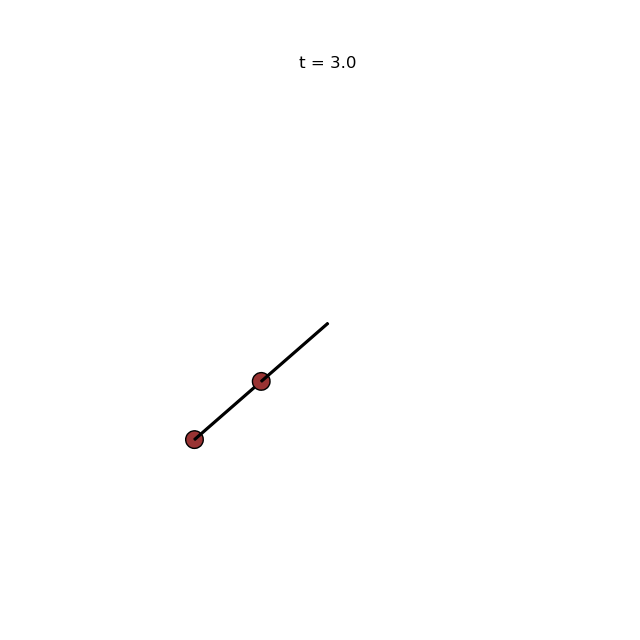

In [3]:
simulate()

But if we've gone this far, we could have replaced the dynamics with almost anything.  For instance, with a simple change, we can use feedback cancellation to invert gravity!

<IPython.core.display.Javascript object>


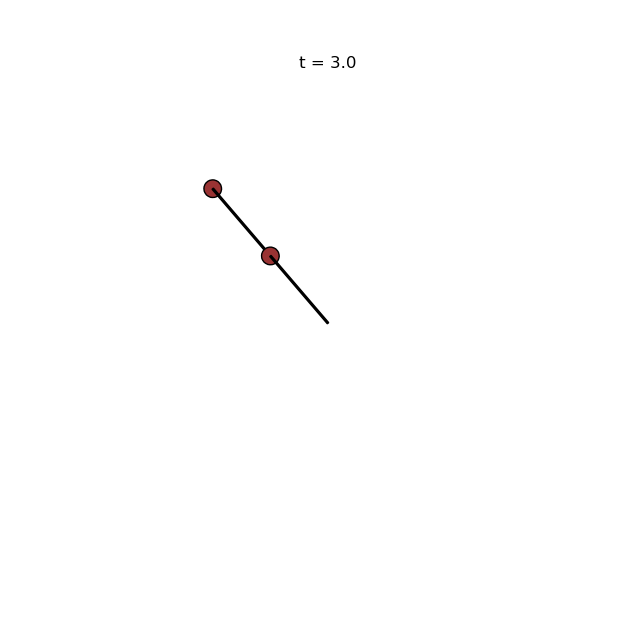

In [4]:
simulate(gravity=9.8)